## Test clip

In [1]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Autres models disponibles :
# model, preprocess = clip.load("RN50", device=device)
# model, preprocess = clip.load("RN101", device=device)
# model, preprocess = clip.load("RN50x4", device=device)
# model, preprocess = clip.load("RN50x16", device=device)

image = preprocess(Image.open("Fond d'ecran 2.jpg")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

print("Image features shape:", image_features.shape)
print(image_features)

Label probs: [[0.19456345 0.2209142  0.5845223 ]]
Image features shape: torch.Size([1, 512])
tensor([[-5.0393e-01, -2.1204e-01, -2.3287e-01,  5.0777e-01,  3.9405e-01,
         -2.8840e-01, -2.3485e-01,  2.4387e-01,  2.2658e-01,  2.0141e-01,
          1.2207e-01, -2.4034e-01,  1.0261e+00, -2.1679e-01,  1.7435e-01,
          4.3351e-01, -1.1091e+00,  1.6566e-01,  1.6250e-01, -3.4010e-01,
         -3.8880e-01,  1.7964e-01, -1.6063e-01, -5.5768e-01,  1.9361e-01,
         -1.6445e-01,  3.6703e-03, -2.1452e-01, -6.3473e-01, -2.1212e-01,
         -2.3543e-01,  2.4408e-01,  5.8717e-02, -1.2163e-01,  3.2592e-01,
          2.3374e-01,  2.1398e-01, -2.6841e-01,  3.0833e-01, -3.6965e-01,
          1.0021e-01, -1.3779e-01,  2.7024e-01, -1.8348e-01, -2.7772e-01,
          1.2578e+00, -5.5255e-02, -1.5480e-02, -2.2599e-01,  4.1163e-01,
          1.3079e-01,  3.1992e-01,  3.8755e-01,  1.1978e-02, -1.3777e-01,
         -1.4113e-01,  9.4241e-02,  5.0071e-01, -1.4645e-01, -8.0164e-02,
          3.9268e-0

In [2]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100


device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

# Préparation
image, class_id = cifar100[3637]
image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)


with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Top 5 des prédictions
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")


Top predictions:

           snake: 65.31%
          turtle: 12.29%
    sweet_pepper: 3.83%
          lizard: 1.88%
       crocodile: 1.75%


## Test avec la MI

In [3]:
# Similarity cosinus 

def similarity_cosine( X, Z):
    prod_scalar = torch.matmul(X, Z.T)
    norm_X = torch.norm(X, dim=1, keepdim=True)
    norm_Z = torch.norm(Z, dim=1, keepdim=True)
    return prod_scalar / (norm_X @ norm_Z.T)     
    

In [4]:
# Mutual information
from sklearn.metrics import mutual_info_score
import numpy as np

def hist2d(x, y, bins):
    """Calcule l'histogramme 2D normalisé de x et y"""
    hist, _, _ = np.histogram2d(x, y, bins=bins)
    hist = hist / np.sum(hist)  # Normalisation pour obtenir une distribution de probabilité
    return hist

def mutual_information(x, y):
    """Calcule l'information mutuelle entre deux variables x et y"""
    return mutual_info_score(x, y)

In [5]:
import random

def base2(n):
    """Convertit un entier n en une liste de bits (base 2)"""
    bits = [0]*8  # Initialise une liste de 8 bits à 0
    k=1
    while n > 0:
        bits[len(bits)-k] = n % 2  # Stocke le bit le plus à droite
        k+=1
        n //= 2
    return bits  # Retourne la liste dans l'ordre correct

def base10(bits):
    """Convertit une liste de bits (base 2) en un entier n"""
    n = 0
    for i in range(len(bits)):
        n += bits[len(bits)-1-i] * (2**i)  # Calcule la valeur décimale
    return n

def encryptage (image,s):
    random.seed(42)  # Pour reproductibilité des résultats
    image_encrypted = image.copy() 
    for i in range (len (image)):
        for j in range (len(image[0])):
            bits = base2(image[i][j])
            for p in range (0, s):
                k = random.randint(0, 1)
                bits[p] = bits[p] ^ k
            image_encrypted[i][j] = base10(bits)

    return image_encrypted

In [18]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
from PIL import Image as PILImage

path_img = "IMG_20210408_141933.jpg"
img = imread(path_img)
imggray = (img[:,:,0]*255).astype(int)

In [23]:
S = [i for i in range(0, 8)]
mi_clip_scores = []
cos_sim_scores_clip = []

for s in S:
    img_encrypted = encryptage(imggray, s)
    
    img_original_pil = PILImage.fromarray(imggray.astype('uint8'), mode='L').convert('RGB')
    img_encrypted_pil = PILImage.fromarray(img_encrypted.astype('uint8'), mode='L').convert('RGB')
    
    # Resize nécessaire?
    img_original_tensor = preprocess(img_original_pil).unsqueeze(0).to(device)
    img_encrypted_tensor = preprocess(img_encrypted_pil).unsqueeze(0).to(device)
    
    with torch.no_grad():
        features_original = model.encode_image(img_original_tensor)
        features_encrypted = model.encode_image(img_encrypted_tensor)
    
    feat_orig_np = features_original.cpu().numpy().flatten()
    feat_enc_np = features_encrypted.cpu().numpy().flatten()
    
    # Fix: add unsqueeze for similarity_cosine
    cos_sim = similarity_cosine(torch.tensor(feat_orig_np).unsqueeze(0), torch.tensor(feat_enc_np).unsqueeze(0)).item()
    cos_sim_scores_clip.append(cos_sim)

    # Discretization for MI
    bins = 50
    feat_orig_discrete = np.digitize(feat_orig_np, bins=np.linspace(feat_orig_np.min(), feat_orig_np.max(), bins))
    feat_enc_discrete = np.digitize(feat_enc_np, bins=np.linspace(feat_enc_np.min(), feat_enc_np.max(), bins))
    
    mi_score = mutual_info_score(feat_orig_discrete, feat_enc_discrete)
    mi_clip_scores.append(mi_score)
    
    print(f"s={s}: MI = {mi_score:.4f}, Cosine Sim = {cos_sim:.4f}")



s=0: MI = 1.9060, Cosine Sim = 1.0000
s=1: MI = 0.3766, Cosine Sim = 0.8251
s=2: MI = 0.2082, Cosine Sim = 0.7362
s=3: MI = 0.1877, Cosine Sim = 0.7272
s=4: MI = 0.1880, Cosine Sim = 0.6926
s=5: MI = 0.1804, Cosine Sim = 0.6812
s=6: MI = 0.1724, Cosine Sim = 0.6739
s=7: MI = 0.1767, Cosine Sim = 0.6761


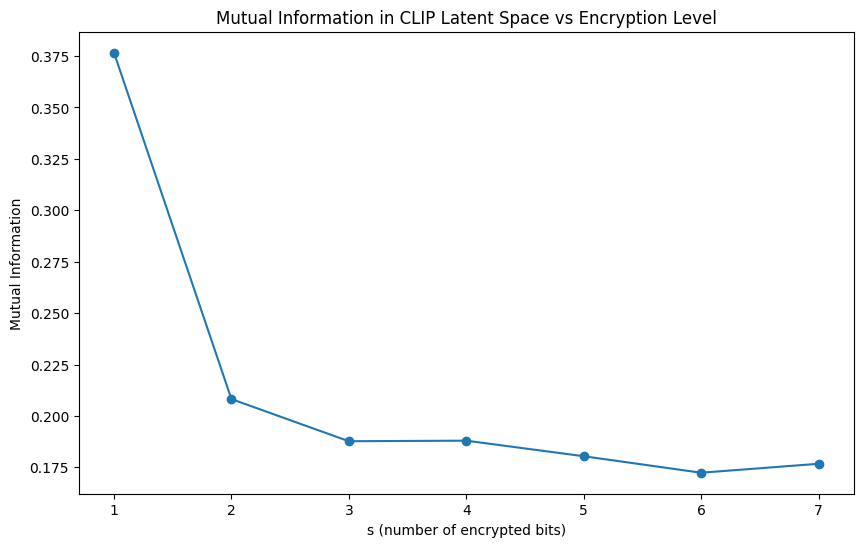

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(S[1:], mi_clip_scores[1:], 'o-')
plt.xlabel('s (number of encrypted bits)')
plt.ylabel('Mutual Information')
plt.title('Mutual Information in CLIP Latent Space vs Encryption Level')
plt.show()

In [22]:

mi_pixel_scores = []
cos_sim_scores_pixel = []

def similarity_cosine_2( X, Z):
    return torch.nn.functional.cosine_similarity(X, Z)

for s in S:
    x = imggray.flatten()
    y = encryptage(imggray, s).flatten()
    mi_pixel = mutual_info_score(x, y)
    mi_pixel_scores.append(mi_pixel)
    
    x_tensor = torch.tensor(x, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    
    cos_sim = torch.nn.functional.cosine_similarity(x_tensor.unsqueeze(0), y_tensor.unsqueeze(0), dim=1).item()
    cos_sim_scores_pixel.append(cos_sim)



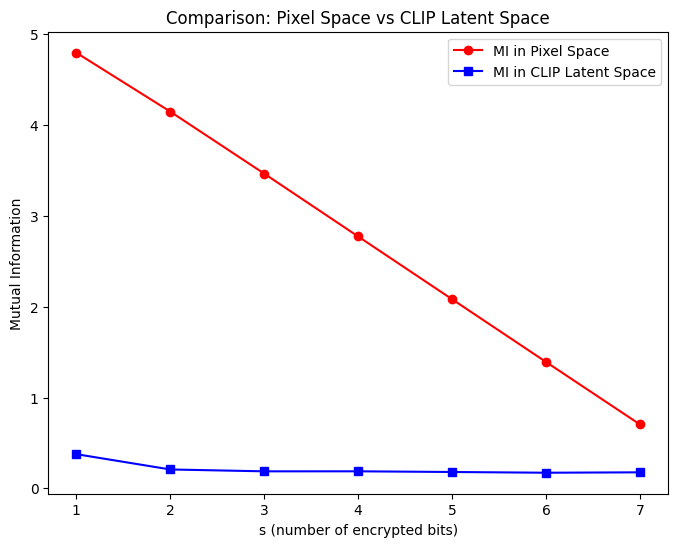

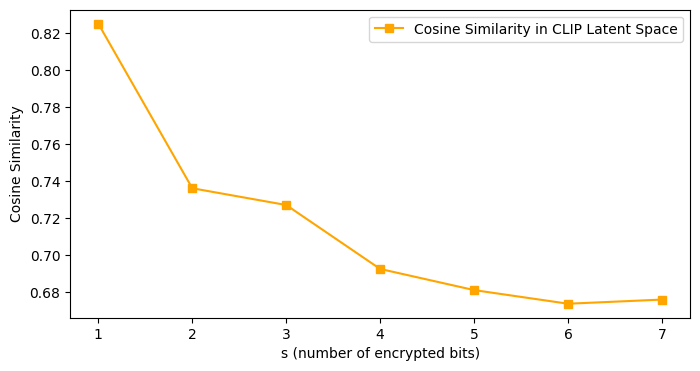

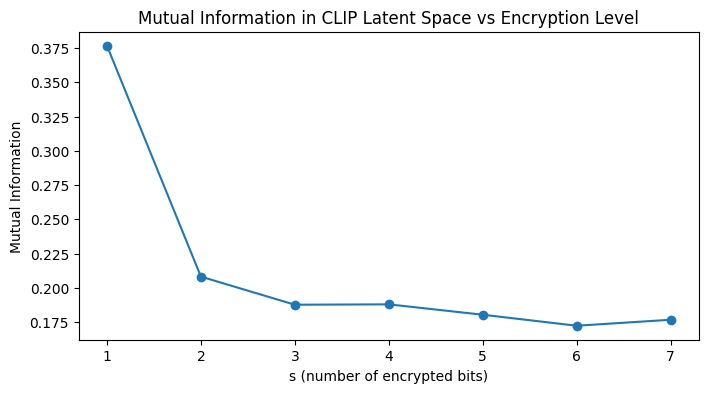

In [ ]:
# Plot comparison
plt.figure(figsize=(8, 6))
plt.plot(S[1:], mi_pixel_scores[1:], 'o-', label='MI in Pixel Space', color='red')
plt.plot(S[1:], mi_clip_scores[1:], 's-', label='MI in CLIP Latent Space', color='blue')
plt.xlabel('s (number of encrypted bits)')
plt.ylabel('Mutual Information')
plt.title('Comparison: Pixel Space vs CLIP Latent Space')
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(S[1:], cos_sim_scores_clip[1:], 's-', label='Cosine Similarity in CLIP Latent Space', color='orange')
plt.xlabel('s (number of encrypted bits)')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(S[1:], mi_clip_scores[1:], 'o-')
plt.xlabel('s (number of encrypted bits)')
plt.ylabel('Mutual Information')
plt.title('Mutual Information in CLIP Latent Space vs Encryption Level')
plt.show()

#adapter l'echelle, trouver des représentations, log, enlever la 1ere valeur et faire des stats sur + d'image
# Estimateur pour les corrélations entres métriques et MI
# Estimateur knn et kde


In [ ]:
from torchvision.models import resnet50

model = resnet50(pretrained=True, progress =True)



In [ ]:
# VAE implementation with PyTorch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, input_dim=224*224*3, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder: input -> hidden -> mu, logvar
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder: latent -> hidden -> output
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        """Encoder: returns mean and log variance of latent distribution"""
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick: sample from N(mu, var)"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        """Decoder: reconstructs input from latent code"""
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 224*224*3))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Initialize VAE
vae_pytorch = VAE(input_dim=224*224*3, hidden_dim=400, latent_dim=512).to(device)
vae_pytorch.eval()

# Preprocessing function for PyTorch VAE
def preprocess_for_pytorch_vae(img_pil):
    """Convert PIL image to tensor for PyTorch VAE"""
    from torchvision import transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    return transform(img_pil).unsqueeze(0).to(device)

# Calculate MI with PyTorch VAE
mi_pytorch_vae_scores = []

print("Computing MI with PyTorch VAE...")
with torch.no_grad():
    for s in S:
        img_encrypted = encryptage(imggray, s)
        
        img_original_pil = PILImage.fromarray(imggray.astype('uint8'), mode='L').convert('RGB')
        img_encrypted_pil = PILImage.fromarray(img_encrypted.astype('uint8'), mode='L').convert('RGB')
        
        img_original_tensor = preprocess_for_pytorch_vae(img_original_pil)
        img_encrypted_tensor = preprocess_for_pytorch_vae(img_encrypted_pil)
        
        # Encode with PyTorch VAE
        mu_orig, _ = vae_pytorch.encode(img_original_tensor.view(-1, 224*224*3))
        mu_enc, _ = vae_pytorch.encode(img_encrypted_tensor.view(-1, 224*224*3))
        
        feat_orig_vae = mu_orig.cpu().numpy().flatten()
        feat_enc_vae = mu_enc.cpu().numpy().flatten()
        
        # Discretization
        bins = 50
        feat_orig_discrete = np.digitize(feat_orig_vae, bins=np.linspace(feat_orig_vae.min(), feat_orig_vae.max(), bins))
        feat_enc_discrete = np.digitize(feat_enc_vae, bins=np.linspace(feat_enc_vae.min(), feat_enc_vae.max(), bins))
        
        mi_score = mutual_info_score(feat_orig_discrete, feat_enc_discrete)
        mi_pytorch_vae_scores.append(mi_score)
        
        print(f"s={s}: MI PyTorch VAE = {mi_score:.4f}")

# Comparison plot: Pixel vs CLIP vs PyTorch VAE
plt.figure(figsize=(14, 7))
plt.plot(S, mi_pixel_scores, 'o-', label='MI Pixel Space', color='red')
plt.plot(S, mi_clip_scores, 's-', label='MI CLIP Latent Space', color='blue')
plt.plot(S, mi_pytorch_vae_scores, '^-', label='MI PyTorch VAE', color='green')
plt.xlabel('s (number of encrypted bits)')
plt.ylabel('Mutual Information')
plt.title('Comparison: Pixel Space vs CLIP vs PyTorch VAE')
plt.legend()
plt.grid(True)
plt.show()

print("\n=== Summary for s=7 (maximum encryption) ===")
print(f"MI Pixel Space: {mi_pixel_scores[-1]:.4f}")
print(f"MI CLIP:        {mi_clip_scores[-1]:.4f}")
print(f"MI PyTorch VAE: {mi_pytorch_vae_scores[-1]:.4f}")